In [1]:
import pandas as pd
import scipy
import sys
import sklearn.preprocessing
from implicit.als import AlternatingLeastSquares
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import precision_score, recall_score
import mlflow
import os
import joblib
import json

In [2]:
data = pd.read_parquet('data/preprocessed_data.parquet')

#### Разбиение данных

In [3]:
# В качестве точки разбиения возьму дату 01.01.2016
train_test_global_time_split_date = pd.to_datetime("2016-01-01")

train_test_global_time_split_idx = data["fecha_dato"] < train_test_global_time_split_date
events_train = data[train_test_global_time_split_idx]
events_test = data[~train_test_global_time_split_idx]

### Персональные рекомендации

In [4]:
# перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
events_train["user_id_enc"] = user_encoder.fit_transform(events_train["ncodpers"])

/tmp/ipykernel_2510/888135567.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["user_id_enc"] = user_encoder.fit_transform(events_train["ncodpers"])


Для создания csr матрицы нужно изменить датасет. Оставлю только столбец с индексами пользователей и столбцы с взаимодействиями. Агрегирую данные по пользователям, в столбцах с взаимодействиями с товарами оставлю сумму взаимодействий, так как для одного полтьзователя может быть несколько строк в которых он взаимодействует с одним и тем же товаром.

In [5]:
data_to_csr = events_train[['user_id_enc', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
                            'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
                            'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
                            'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
                            'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
                            'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
                            'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
                            'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']]

data_to_csr = data_to_csr.groupby("user_id_enc").any().reset_index()

In [6]:
item_columns = data_to_csr.columns[1:]  # Все, кроме user_id

# Преобразуем в numpy-массив
matrix = data_to_csr[item_columns].values 

# создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix(matrix)

In [7]:
#  размер sparse-матрицы формата CSR  в гигабайтах
sum([sys.getsizeof(i) for i in user_item_matrix_train.data])/1024**3

0.03139327745884657

In [8]:
# создание и тренировка модели
als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

/home/mle-user/sprints/mle-pr-final/.venv_final/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

In [10]:
# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=10)

In [11]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

In [12]:
als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})

In [13]:
als_recommendations = als_recommendations.explode(["item_id", "score"], ignore_index=True)

In [14]:
# приводим типы данных
als_recommendations["item_id"] = als_recommendations["item_id"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

In [15]:
als_recommendations.head(10)

,user_id_enc,item_id,score
0,0,2,1.013371
1,0,8,1.000471
2,0,18,1.000344
3,0,19,1.000204
4,0,0,0.000625
5,0,3,0.000589
6,0,23,0.000525
7,0,12,0.000508
8,0,15,0.000444
9,0,17,0.000431


In [16]:
item_id_and_name = {0: 'ind_ahor_fin_ult1', 1: 'ind_aval_fin_ult1', 2: 'ind_cco_fin_ult1',
                    3: 'ind_cder_fin_ult1', 4: 'ind_cno_fin_ult1', 5: 'ind_ctju_fin_ult1',
                    6: 'ind_ctma_fin_ult1', 7: 'ind_ctop_fin_ult1', 8: 'ind_ctpp_fin_ult1',
                    9: 'ind_deco_fin_ult1', 10: 'ind_deme_fin_ult1', 11: 'ind_dela_fin_ult1',
                    12: 'ind_ecue_fin_ult1', 13: 'ind_fond_fin_ult1', 14: 'ind_hip_fin_ult1',
                    15: 'ind_plan_fin_ult1', 16: 'ind_pres_fin_ult1', 17: 'ind_reca_fin_ult1',
                    18: 'ind_tjcr_fin_ult1', 19: 'ind_valo_fin_ult1', 20: 'ind_viv_fin_ult1',
                    21: 'ind_nomina_ult1', 22: 'ind_nom_pens_ult1', 23: 'ind_recibo_ult1'}

In [17]:
als_recommendations['item_name'] = als_recommendations['item_id'].replace(item_id_and_name)

In [18]:
als_recommendations['ncodpers'] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])

In [19]:
als_recommendations

,user_id_enc,item_id,score,item_name,ncodpers
0,0,2,1.013371,ind_cco_fin_ult1,15889
1,0,8,1.000471,ind_ctpp_fin_ult1,15889
2,0,18,1.000344,ind_tjcr_fin_ult1,15889
3,0,19,1.000204,ind_valo_fin_ult1,15889
4,0,0,0.000625,ind_ahor_fin_ult1,15889
...,...,...,...,...,...
8937055,893705,4,0.000000,ind_cno_fin_ult1,1520376
8937056,893705,3,0.000000,ind_cder_fin_ult1,1520376
8937057,893705,2,0.000000,ind_cco_fin_ult1,1520376
8937058,893705,1,0.000000,ind_aval_fin_ult1,1520376


In [20]:
als_recommendations.to_parquet("models_and_recommendations/personal_als.parquet")
joblib.dump(als_model, 'models_and_recommendations/als_model.joblib')
joblib.dump(user_encoder, 'models_and_recommendations/user_encoder.joblib')

['models_and_recommendations/user_encoder.joblib']

In [22]:
# логирование ALS модели в MLflow
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") 


TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "Bank_recommendations"
RUN_NAME = "personal_recommendations_ALS"

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")


experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.sklearn.log_model(user_encoder, "user_encoder") 

    model_info = mlflow.sklearn.log_model( 
		sk_model=als_model, artifact_path='models', registered_model_name='als_model')

2025/04/08 15:02:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/08 15:02:38 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
Successfully registered model 'als_model'.
2025/04/08 15:02:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: als_model, version 1
Created version '1' of model 'als_model'.


### Топ популярных

Топ популярых продуктов вычислю, посчитав в каждом столбце с продуктом количество единиц.

In [4]:
target_columns = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
                'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
                'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
                'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
                'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
                'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
                'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
                'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']

In [5]:
product_popularity = {}
for column in target_columns:
    product_popularity[column] = events_train[column].sum()

In [6]:
product_popularity = dict(sorted(product_popularity.items(), key=lambda x: x[1], reverse=True))

In [7]:
product_popularity

{'ind_cco_fin_ult1': 5960471,
 'ind_ctop_fin_ult1': 1196623,
 'ind_recibo_ult1': 1148109,
 'ind_ecue_fin_ult1': 734446,
 'ind_cno_fin_ult1': 723635,
 'ind_nom_pens_ult1': 542593.0,
 'ind_nomina_ult1': 500282.0,
 'ind_reca_fin_ult1': 454781,
 'ind_tjcr_fin_ult1': 410867,
 'ind_dela_fin_ult1': 405339,
 'ind_ctpp_fin_ult1': 402828,
 'ind_valo_fin_ult1': 226167,
 'ind_fond_fin_ult1': 166773,
 'ind_ctma_fin_ult1': 87370,
 'ind_ctju_fin_ult1': 87263,
 'ind_plan_fin_ult1': 82414,
 'ind_hip_fin_ult1': 55432,
 'ind_viv_fin_ult1': 35323,
 'ind_pres_fin_ult1': 24033,
 'ind_deco_fin_ult1': 21523,
 'ind_deme_fin_ult1': 16590,
 'ind_cder_fin_ult1': 3611,
 'ind_ahor_fin_ult1': 918,
 'ind_aval_fin_ult1': 201}

буду использовать первые 5 продуктов.

In [11]:
list(product_popularity.keys())

['ind_cco_fin_ult1',
 'ind_ctop_fin_ult1',
 'ind_recibo_ult1',
 'ind_ecue_fin_ult1',
 'ind_cno_fin_ult1',
 'ind_nom_pens_ult1',
 'ind_nomina_ult1',
 'ind_reca_fin_ult1',
 'ind_tjcr_fin_ult1',
 'ind_dela_fin_ult1',
 'ind_ctpp_fin_ult1',
 'ind_valo_fin_ult1',
 'ind_fond_fin_ult1',
 'ind_ctma_fin_ult1',
 'ind_ctju_fin_ult1',
 'ind_plan_fin_ult1',
 'ind_hip_fin_ult1',
 'ind_viv_fin_ult1',
 'ind_pres_fin_ult1',
 'ind_deco_fin_ult1',
 'ind_deme_fin_ult1',
 'ind_cder_fin_ult1',
 'ind_ahor_fin_ult1',
 'ind_aval_fin_ult1']

In [12]:
with open('models_and_recommendations/product_popularity.json', 'w') as f:
    json.dump(list(product_popularity.keys()), f)

### Ранжирование рекомендаций

#### Подготовка данных

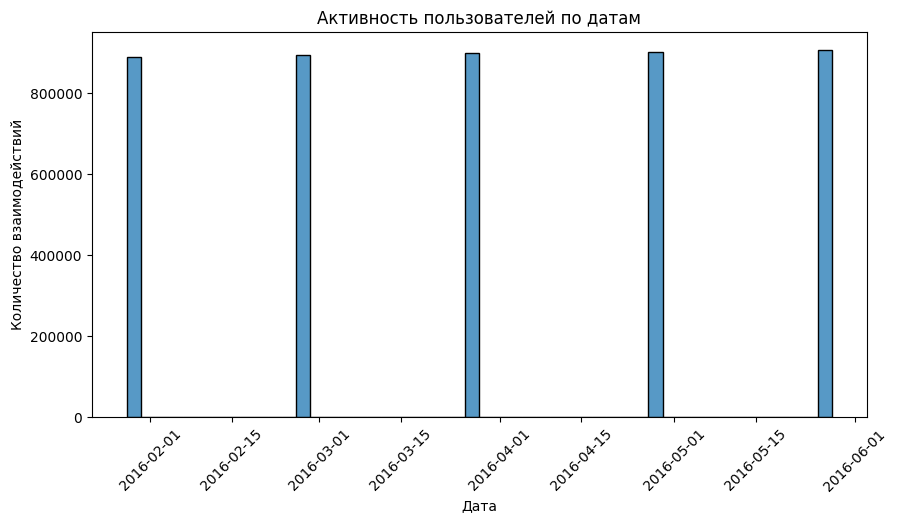

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(events_test['fecha_dato'], bins=50)

plt.xlabel("Дата")
plt.ylabel("Количество взаимодействий")
plt.title("Активность пользователей по датам")
plt.xticks(rotation=45) 

plt.show()

Разобью отложенную раньше тестовую выборку на train и rank для ранжирующей модели.

In [5]:
als_recommendations = pd.read_parquet('models_and_recommendations/personal_als.parquet')

In [6]:
events_labels = events_test.copy()

In [7]:
# В качестве точки разбиения возьму дату 01.04.2016
train_test_global_time_split_date = pd.to_datetime("2016-04-01")

train_test_global_time_split_idx = events_labels["fecha_dato"] < train_test_global_time_split_date
events_labels_train = events_labels[train_test_global_time_split_idx]
events_labels_rank = events_labels[~train_test_global_time_split_idx]

##### train

In [8]:
events_labels_train.columns

Index(['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel', 'indrel_1mes',
       'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall',
       'cod_prov', 'nomprov', 'ind_actividad_cliente', 'renta', 'segmento',
       'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1'],
      dtype='object')

In [9]:
# Удалю дубликаты по столбцу 'ncodpers', оставляя первый экземпляр
train_users = events_labels_train.drop_duplicates(subset='ncodpers', keep='first')
# Оставлю только столбцы с признаками
train_users = train_users[['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
                            'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel', 'indrel_1mes',
                            'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall',
                            'cod_prov', 'nomprov', 'ind_actividad_cliente', 'renta', 'segmento']]

In [10]:
train_targets = events_labels_train[['ncodpers', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
                                    'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
                                    'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
                                    'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
                                    'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
                                    'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
                                    'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
                                    'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']]

train_targets = train_targets.groupby("ncodpers").any().reset_index()

In [11]:
candidates_for_train = train_users.merge(train_targets, on=["ncodpers"], how="left")

Остались только уникальные записи пользователей, у которых в столбцах с продуктами хранятся факты взаимодействий.

Теперь нужно создать столбец item_id_enc, в котором будут храниться идентификаторы продуктов, и столбец target, в котором будут факты взаимодействий.

In [12]:
feature_columns = ['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
                    'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel', 'indrel_1mes',
                    'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall',
                    'cod_prov', 'nomprov', 'ind_actividad_cliente', 'renta', 'segmento']

In [13]:
candidates_for_train = candidates_for_train.melt(id_vars=feature_columns, var_name='item_name', value_name='target')

# Оставлю только взаимодействия, где target = 1
candidates_for_train = candidates_for_train[candidates_for_train['target'] == 1]

In [14]:
candidates_for_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1240199 entries, 17761 to 21653939
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   fecha_dato             1240199 non-null  datetime64[ns]
 1   ncodpers               1240199 non-null  int64         
 2   ind_empleado           1240199 non-null  object        
 3   pais_residencia        1240199 non-null  object        
 4   sexo                   1240199 non-null  object        
 5   age                    1240199 non-null  int64         
 6   fecha_alta             1240199 non-null  datetime64[ns]
 7   ind_nuevo              1240199 non-null  float64       
 8   antiguedad             1240199 non-null  int64         
 9   indrel                 1240199 non-null  float64       
 10  indrel_1mes            1240199 non-null  object        
 11  tiprel_1mes            1240199 non-null  object        
 12  indresi                12401

In [15]:
candidates_for_train = als_recommendations.merge(candidates_for_train, on=["ncodpers", "item_name"], how="left")
candidates_for_train["target"] = candidates_for_train["target"].fillna(0).astype("int")

In [16]:
candidates_for_train

,user_id_enc,item_id,score,item_name,ncodpers,fecha_dato,ind_empleado,pais_residencia,sexo,age,...,indresi,indext,canal_entrada,indfall,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,target
0,0,2,1.013371,ind_cco_fin_ult1,15889,2016-01-28,F,ES,V,56.0,...,S,N,KAT,N,28.0,MADRID,1.0,326124.9,TOP,1
1,0,8,1.000471,ind_ctpp_fin_ult1,15889,2016-01-28,F,ES,V,56.0,...,S,N,KAT,N,28.0,MADRID,1.0,326124.9,TOP,1
2,0,18,1.000344,ind_tjcr_fin_ult1,15889,2016-01-28,F,ES,V,56.0,...,S,N,KAT,N,28.0,MADRID,1.0,326124.9,TOP,1
3,0,19,1.000204,ind_valo_fin_ult1,15889,2016-01-28,F,ES,V,56.0,...,S,N,KAT,N,28.0,MADRID,1.0,326124.9,TOP,1
4,0,0,0.000625,ind_ahor_fin_ult1,15889,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8937055,893705,4,0.000000,ind_cno_fin_ult1,1520376,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8937056,893705,3,0.000000,ind_cder_fin_ult1,1520376,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8937057,893705,2,0.000000,ind_cco_fin_ult1,1520376,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8937058,893705,1,0.000000,ind_aval_fin_ult1,1520376,NaT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Необходимо заполнить пропуски в таблице

In [17]:
# Вынесу уникальные взаимодействия в отдельную таблицу
interactions = candidates_for_train[['item_id', 'score', 'item_name', 'target']]

In [18]:
# Заполню пропуски в таблице
candidates_for_train.fillna(candidates_for_train.groupby("ncodpers").transform("first"), inplace=True)

In [19]:
# Верну в таблицу уникальные значения
candidates_for_train['item_id'] = interactions['item_id']
candidates_for_train['score'] = interactions['score']
candidates_for_train['item_name'] = interactions['item_name']
candidates_for_train['target'] = interactions['target']

In [20]:
candidates_for_train.isna().sum()

user_id_enc                    0
item_id                        0
score                          0
item_name                      0
ncodpers                       0
fecha_dato               2272390
ind_empleado             2272390
pais_residencia          2272390
sexo                     2272390
age                      2272390
fecha_alta               2272390
ind_nuevo                2272390
antiguedad               2272390
indrel                   2272390
indrel_1mes              2272390
tiprel_1mes              2272390
indresi                  2272390
indext                   2272390
canal_entrada            2272390
indfall                  2272390
cod_prov                 2272390
nomprov                  2272390
ind_actividad_cliente    2272390
renta                    2272390
segmento                 2272390
target                         0
dtype: int64

В таблице ещё приутствуют пропущенные значения. Это данные о пользователях, которые не взаимодействовали с продуктами в новой тренировочной выборке, но для них составлены рекомендации. Удалю строки с этими пользователями, так как они не отличаются от новых клиенов.

In [21]:
candidates_for_train.dropna(inplace=True)

In [22]:
candidates_for_train.to_parquet("models_and_recommendations/candidates_for_train.parquet")

##### rank

Тут сделаю тоже самое, что и с train.

In [23]:
test_users = events_labels_rank.drop_duplicates(subset='ncodpers', keep='first')

test_users = test_users[['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
                            'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel', 'indrel_1mes',
                            'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall',
                            'cod_prov', 'nomprov', 'ind_actividad_cliente', 'renta', 'segmento']]

In [24]:
test_targets = events_labels_rank[['ncodpers', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
                                    'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
                                    'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
                                    'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
                                    'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
                                    'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
                                    'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
                                    'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']]

test_targets = test_targets.groupby("ncodpers").any().reset_index()

In [25]:
candidates_to_rank = test_users.merge(test_targets, on=["ncodpers"], how="left")

In [26]:
candidates_to_rank = candidates_to_rank.melt(id_vars=feature_columns, var_name='item_name', value_name='target')

candidates_to_rank = candidates_to_rank[candidates_to_rank['target'] == 1]

In [27]:
candidates_to_rank = als_recommendations.merge(candidates_to_rank, on=["ncodpers", "item_name"], how="left")
candidates_to_rank["target"] = candidates_to_rank["target"].fillna(0).astype("int")

In [28]:
interactions = candidates_to_rank[['item_id', 'score', 'item_name', 'target']]

In [29]:
candidates_to_rank.fillna(candidates_to_rank.groupby("ncodpers").transform("first"), inplace=True)

In [30]:
candidates_to_rank['item_id'] = interactions['item_id']
candidates_to_rank['score'] = interactions['score']
candidates_to_rank['item_name'] = interactions['item_name']
candidates_to_rank['target'] = interactions['target']

In [31]:
candidates_to_rank.dropna(inplace=True)

In [32]:
candidates_to_rank.to_parquet("models_and_recommendations/candidates_to_rank.parquet")

#### Обучение ранжирующей модели

In [4]:
candidates_for_train = pd.read_parquet("models_and_recommendations/candidates_for_train.parquet")
candidates_to_rank = pd.read_parquet("models_and_recommendations/candidates_to_rank.parquet")

In [5]:
# задаём имена колонок признаков и таргета
features = ['item_id', 'score','ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
            'age', 'ind_nuevo', 'antiguedad', 'indrel', 'indrel_1mes',
            'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall',
            'cod_prov', 'nomprov', 'ind_actividad_cliente', 'renta', 'segmento']
cat_features = ['ind_empleado', 'pais_residencia', 'sexo', 'indrel_1mes',
                 'tiprel_1mes', 'indresi', 'indext', 'canal_entrada', 'indfall', 'nomprov', 'segmento']
target = 'target'

# создаём Pool
train_data = Pool(
    data=candidates_for_train[features], 
    cat_features=cat_features,
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=4,
    loss_function='Logloss',
    verbose=20,
    random_seed=0,
)

# тренируем модель
cb_model.fit(train_data)

0:	learn: 0.4706466	total: 4.64s	remaining: 15m 23s
20:	learn: 0.0736793	total: 1m 13s	remaining: 10m 26s
40:	learn: 0.0686251	total: 2m 25s	remaining: 9m 25s
60:	learn: 0.0660473	total: 3m 37s	remaining: 8m 16s
80:	learn: 0.0643975	total: 4m 50s	remaining: 7m 7s
100:	learn: 0.0633601	total: 6m 2s	remaining: 5m 54s
120:	learn: 0.0624198	total: 7m 13s	remaining: 4m 43s
140:	learn: 0.0616961	total: 8m 25s	remaining: 3m 31s
160:	learn: 0.0609904	total: 9m 36s	remaining: 2m 19s
180:	learn: 0.0604997	total: 10m 44s	remaining: 1m 7s
199:	learn: 0.0598259	total: 11m 52s	remaining: 0us


In [6]:
inference_data = Pool(
    data=candidates_to_rank[features],
    cat_features=cat_features,
    label=candidates_to_rank[target])
predictions = cb_model.predict(inference_data)

candidates_to_rank["cb_score"] = predictions

# для каждого пользователя проставим rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["ncodpers", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby("ncodpers").cumcount() + 1

max_recommendations_per_user = 5
final_recommendations = candidates_to_rank.query("rank <= @max_recommendations_per_user")

In [7]:
# количество пользователей попало в final_recommendations
final_recommendations['ncodpers'].nunique()

661370

In [8]:
# сохранение финальных рекомендаций
final_recommendations.to_parquet("models_and_recommendations/recommendations.parquet")

In [9]:
# сохраниние модели catboost
joblib.dump(cb_model, 'models_and_recommendations/cb_model.joblib')

['models_and_recommendations/cb_model.joblib']

### Оценка качества

In [10]:

recommendations = pd.read_parquet('models_and_recommendations/recommendations.parquet')

In [11]:
recommendations

,user_id_enc,item_id,score,item_name,ncodpers,fecha_dato,ind_empleado,pais_residencia,sexo,age,...,canal_entrada,indfall,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,target,cb_score,rank
0,0,2,1.013371,ind_cco_fin_ult1,15889,2016-04-28,F,ES,V,56.0,...,KAT,N,28.0,MADRID,1.0,326124.9,TOP,1,1,1
1,0,8,1.000471,ind_ctpp_fin_ult1,15889,2016-04-28,F,ES,V,56.0,...,KAT,N,28.0,MADRID,1.0,326124.9,TOP,1,1,2
2,0,18,1.000344,ind_tjcr_fin_ult1,15889,2016-04-28,F,ES,V,56.0,...,KAT,N,28.0,MADRID,1.0,326124.9,TOP,1,1,3
3,0,19,1.000204,ind_valo_fin_ult1,15889,2016-04-28,F,ES,V,56.0,...,KAT,N,28.0,MADRID,1.0,326124.9,TOP,1,1,4
4,0,0,0.000625,ind_ahor_fin_ult1,15889,2016-04-28,F,ES,V,56.0,...,KAT,N,28.0,MADRID,1.0,326124.9,TOP,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8937027,893702,2,0.000000,ind_cco_fin_ult1,1520373,2016-04-28,N,ES,V,74.0,...,KHN,N,50.0,ZARAGOZA,1.0,101850.0,PARTICULARES,0,1,1
8937020,893702,9,0.000000,ind_deco_fin_ult1,1520373,2016-04-28,N,ES,V,74.0,...,KHN,N,50.0,ZARAGOZA,1.0,101850.0,PARTICULARES,0,0,2
8937021,893702,8,0.000000,ind_ctpp_fin_ult1,1520373,2016-04-28,N,ES,V,74.0,...,KHN,N,50.0,ZARAGOZA,1.0,101850.0,PARTICULARES,0,0,3
8937022,893702,7,0.000000,ind_ctop_fin_ult1,1520373,2016-04-28,N,ES,V,74.0,...,KHN,N,50.0,ZARAGOZA,1.0,101850.0,PARTICULARES,0,0,4


In [12]:
precision_final = precision_score(recommendations['target'], recommendations['cb_score'])
recall_final = recall_score(recommendations['target'], recommendations['cb_score'])
coverave_final = recommendations['item_name'].nunique() / 24
novelty_final = (1-recommendations.query("rank <= 5").groupby("ncodpers")["target"].mean()).mean()
print(f'Precision: {precision_final}')
print(f'Recall: {recall_final}')
print(f'Coverage: {coverave_final}')
print(f'Novelty: {novelty_final}')

# добавлю метрики в словарь для логирования в MLflow
metrics = {
    'Precision' : precision_final,
    'Recall' : recall_final,
    'Coverage' : coverave_final,
    'Novelty' : novelty_final
}

Precision: 0.9005432056036121
Recall: 0.9881917080848547
Coverage: 1.0
Novelty: 0.6687687678606528


Судя по метрикам precision и recall модель выдала рекомендации, в соответствии с действиями пользователей в будущем.

Покрытие 100%, а значит в рекомендации попали все продукты банка.

Новизна тоже показывает хорошое значение. Пользователи получают рекомендации по продуктам, которые они раньше не приобретали.

In [13]:
# логирование catboost модели в MLflow
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") 


TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "Bank_recommendations"
RUN_NAME = "final_recommendations"

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_metrics(metrics)

    model_info = mlflow.catboost.log_model(cb_model=cb_model, artifact_path='models', registered_model_name='cb_model')

Successfully registered model 'cb_model'.
2025/04/08 15:38:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: cb_model, version 1
Created version '1' of model 'cb_model'.
